In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils, datasets

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import sklearn

/opt/conda/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
!nvidia-smi

Thu Jun 13 12:57:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.66       Driver Version: 410.66       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:43:00.0 Off |                  N/A |
| 36%   55C    P0    83W / 260W |      0MiB / 10988MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## load image

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
import os
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

data_image = {x:ImageFolderWithPaths(root = os.path.join('./data/image',x),
                                     transform = transform)
              for x in ["train", "test", 'eval']}
batch_size = 32
data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = batch_size,
                                                shuffle = True)
                     for x in ["train", "test", 'eval']}

In [6]:
data_loader_image

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa47eea05c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa47eea05f8>,
 'eval': <torch.utils.data.dataloader.DataLoader at 0x7fa47eea0668>}

('./data/image/train/3/1318857985_0.jpg', './data/image/train/5/1259896424_0.jpg', './data/image/train/1/1143260241_0.jpg', './data/image/train/2/1132097451_0.jpg', './data/image/train/7/1007773522_0.jpg', './data/image/train/5/1076454265_0.jpg', './data/image/train/5/1160540312_0.jpg', './data/image/train/7/1086157784_0.jpg', './data/image/train/1/1111419532_0.jpg', './data/image/train/4/1497367754_0.jpg', './data/image/train/5/1219356350_0.jpg', './data/image/train/7/1310246738_0.jpg', './data/image/train/6/1087329778_0.jpg', './data/image/train/7/1090624333_0.jpg', './data/image/train/5/1219372718_0.jpg', './data/image/train/5/1220264797_0.jpg', './data/image/train/4/1490430032_0.jpg', './data/image/train/6/1282656971_0.jpg', './data/image/train/2/1334006748_0.jpg', './data/image/train/3/1354779888_0.jpg', './data/image/train/5/1677603911_0.jpg', './data/image/train/3/10020132702_0.jpg', './data/image/train/6/1035276881_0.jpg', './data/image/train/7/1056074696_0.jpg', './data/image/

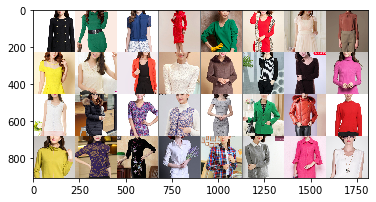

In [7]:
X_train, y_train, X_name = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print(X_name)
print([i for i in y_train])
plt.imshow(img)


In [8]:
net = torchvision.models.resnet152(pretrained=False)
net.fc = torch.nn.Linear(2048, 8)
net = net.to(device)

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
epoch = 10

In [10]:
def train():
    net.train()
    total_loss = 0
    for image, label, name in tqdm(data_loader_image['train'], leave=False):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        target = net(image)
        loss = criterion(target, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    for image, label, name in tqdm(data_loader_image['eval'], leave=False):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        target = net(image)
        loss = criterion(target, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss/float(len(data_loader_image['train']) + len(data_loader_image['eval']))


In [ ]:
for i in tqdm(range(epoch)):
    print(train())

0.5750715441334772


0.5133023248456859


0.4608428211195878


0.41613146276050705


0.37260376453987565


0.3335638427273095


0.2936452976929671


0.264602850585588


In [20]:
torch.save(net, 'train_model_no_pretrain.pkl')

In [ ]:
net = torch.load('train_model_no_pretrain.pkl').to(device)

In [18]:
validation_set = torch.utils.data.DataLoader(dataset=data_image["eval"],
                                                batch_size = 20,
                                                shuffle = False)
def evaluate():
    net.eval()
    corrects = eval_loss = 0

    for image, label, name in tqdm(validation_set, leave=False):
        image = image.to(device)
        label = label.to(device) 
        pred = net(image)
        loss = criterion(pred, label)

        eval_loss += loss.item()
        corrects += (torch.max(pred, 1)[1].view(label.size()).data == label.data).sum()
    return eval_loss/float(len(data_loader_image['eval'])), corrects, corrects*100/batch_size/len(data_loader_image['eval'])

In [19]:
evaluate()

(0.19017234549033812,
 tensor(3971, device='cuda:0'),
 tensor(95, device='cuda:0'))

In [ ]:
test_set = torch.utils.data.DataLoader(dataset=data_image["test"],
                                                batch_size = 1,
                                                shuffle = False)

In [ ]:

def test():
    net.eval()
    corrects = eval_loss = 0
    result = []
    for image, label, name in tqdm(test_set):
        image = image.to(device)
        label = label.to(device) 
        pred = net(image)
        
        result.append([name, torch.max(pred, 1)[1].view(label.size()).data])
    return result

In [ ]:
results = test()

In [ ]:
processed_res = []
for r in results:
    path = r[0][0].split('/')[-1]
    cloth = r[1][0].item()
    processed_res.append([path, cloth])

In [ ]:
res_df = pd.DataFrame(processed_res)
res_df.columns = ['Image', 'Cloth_label']

In [ ]:
res_df.to_csv('res.csv', index=False)